This notebook holds all development of ICA related analysis.  
  
Road map:  
1) Run ICA on running only PSAbool data from open field day -1. Should be able to identify cells with similar place fields!  Sanity check.  
  
2) Run ICA on circa-freezing data only. Another sanity check. Create boolean of freezing times +/- 2 seconds. Should be able to recover cells I have already identified as freeze cells with freezing_analysis.MotionTuning class.  
  
3) Run ICA on non-filtered PSAbool data. Correlate different component activations with freezing and/or velocity to pull out the "freezing" ensembles on day 1.  
  
3a) Track these ensembles backward and forward one session to see how they develop. Should match single cell findings, but maybe we will see something interesting in the ANI vs. Control stuff?

In [1]:
# Import useful modules
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.gridspec as gridspec
import pandas as pd

In [2]:
# Import project specific modules and enable automatic reloading
import sys
from pathlib import Path
import os
eraser_path = Path(os.getcwd()).parent
reinstatement_path = eraser_path.parent / 'FearReinstatement'
sys.path.append(str(eraser_path))
sys.path.append(str(reinstatement_path))
%load_ext autoreload
%autoreload 2

from session_directory import find_eraser_directory as get_dir
import er_plot_functions as erp
import Placefields as pf
import freezing_analysis as fa
import helpers 
import eraser_reference as err

# Project save directory here
print_dir = '/Users/nkinsky/Documents/BU/Working/Eraser/plots'

# First try to recover cells with similar place fields using ICA as a sanity check.

In [3]:
# First define moving average function to smooth things into 1 second
def moving_average(arr, n=20):
    ret = np.cumsum(arr, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def bin_array(arr, n=20):
    return np.add.reduceat(arr, np.arange(0, len(arr), n))


In [40]:
PF.PSAbool_align.shape

(672, 11988)

In [41]:
from sklearn.datasets import load_digits
from sklearn.decomposition import FastICA

PF = pf.load_pf('Marble07', 'Open', -1)

# First bin events
bin_size = 0.5  # sec
PSAsmooth, PSAbin = [], []
for psa in PF.PSAbool_align:
    PSAsmooth.append(moving_average(psa, int(bin_size*PF.sr_image))) # Create moving-average array
    PSAbin.append(bin_array(psa, int(bin_size*PF.sr_image))) # Create non-overlapping bin array
PSAsmooth = np.asarray(PSAsmooth)
PSAbin = np.asarray(PSAbin)

# Now calculate covariance matrix for all your cells using binned array
cov_mat = np.cov(PSAbin)

# # Run ICA on the two different PSAs
transformer = FastICA(n_components=20, random_state=0)
cov_trans = transformer.fit_transform(cov_mat)

# Make into a dataframe for easy plotting
ct_df = pd.DataFrame(cov_trans)
ct_df["cell"] = [str(_) for _ in np.arange(0, ct_df.shape[0])]  # Add in cell # to df (Maybe I need to make this a string to work properly for plotting?)

<IPython.core.display.Javascript object>


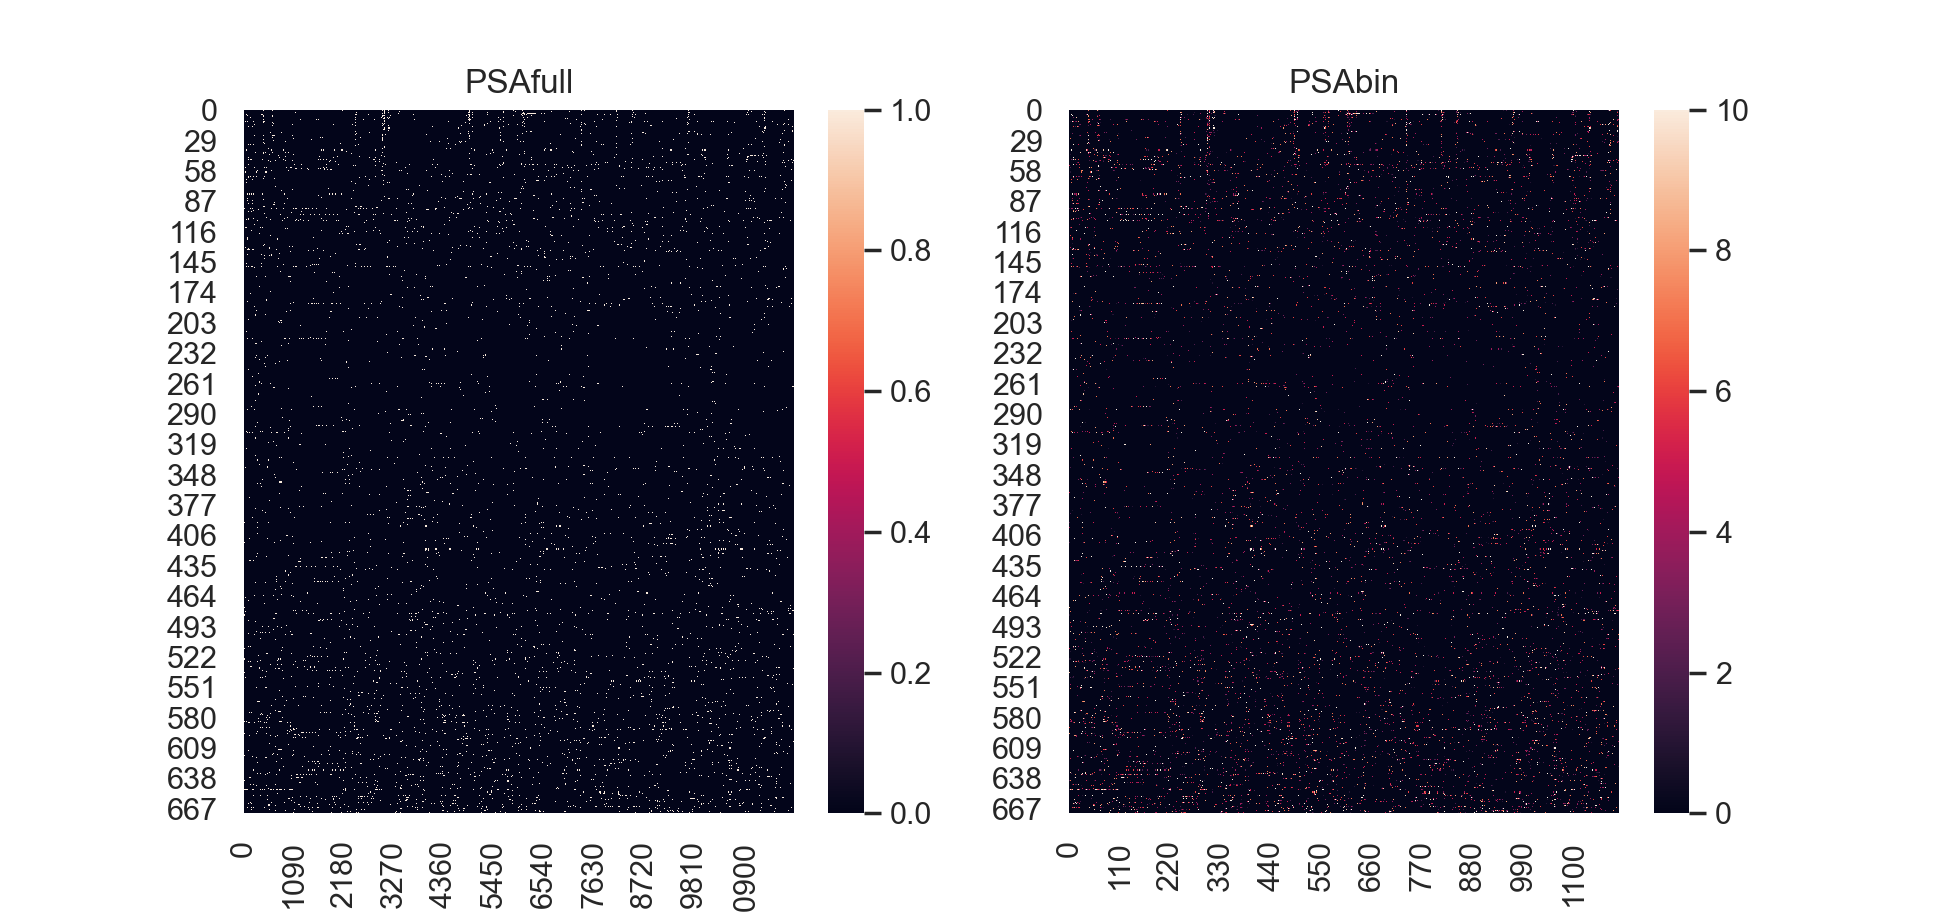

Text(0.5, 1.0, 'PSAbin')

In [43]:
isort0 = ct_df[0].argsort()
ct_df[0][isort0[::-1]]
PSAsort0_bin = PSAbin[isort0[::-1]]
PSAsort0 = PF.PSAbool_align[isort0[::-1]]
fig, ax = plt.subplots(1,2)
sns.heatmap(PSAsort0, ax=ax[0])
ax[0].set_title('PSAfull')
sns.heatmap(PSAsort0_bin, ax=ax[1])
ax[1].set_title('PSAbin')

<IPython.core.display.Javascript object>


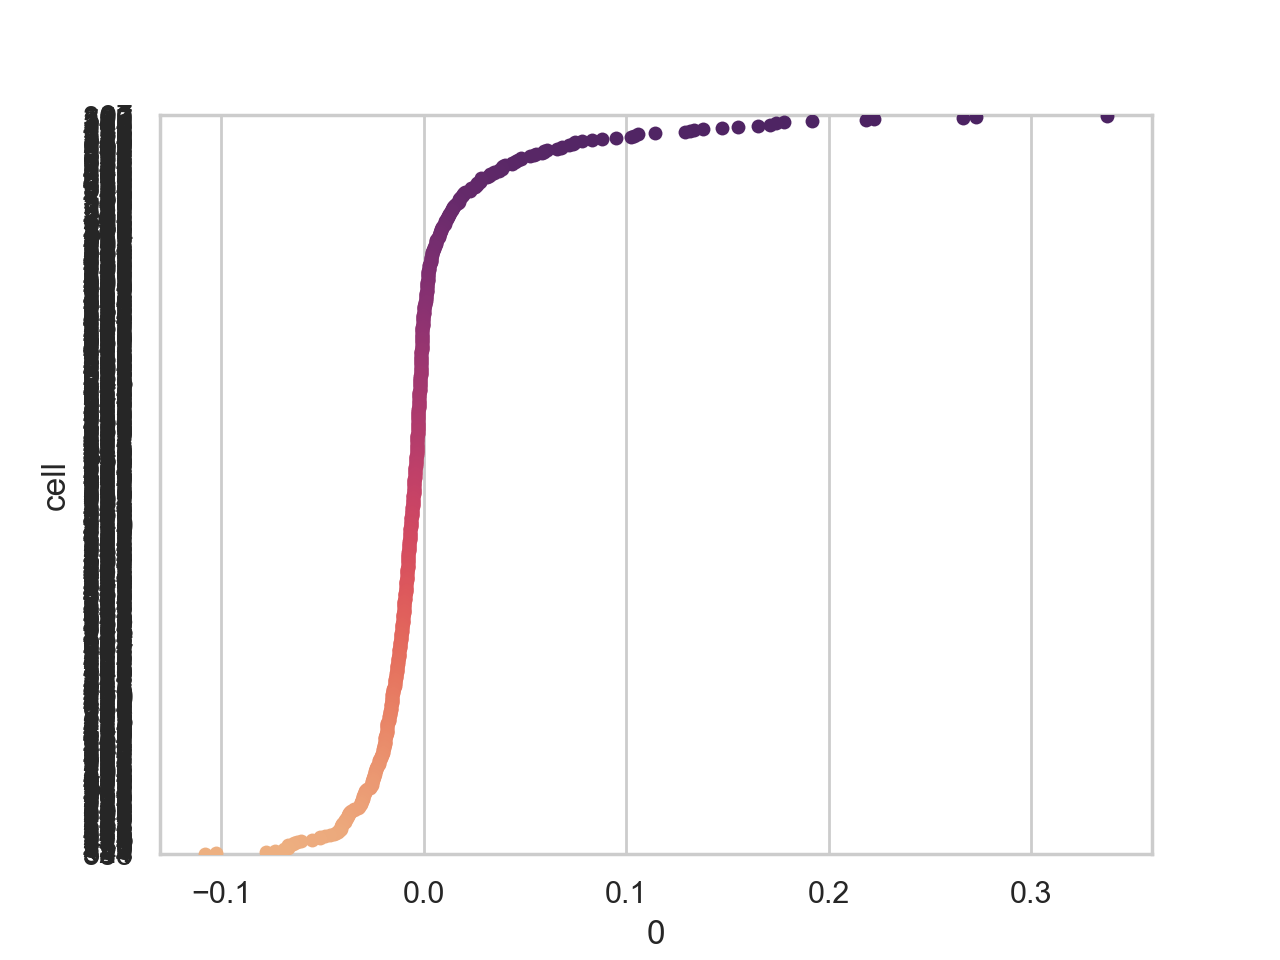

<AxesSubplot:xlabel='0', ylabel='cell'>

In [28]:
%matplotlib notebook
fig, ax = plt.subplots()
ct_df.sort_values(0, ascending=False)
sns.stripplot(data=ct_df.sort_values(0, ascending=False), y='cell', x=0, 
              orient='h', jitter=False, palette='flare_r')

<IPython.core.display.Javascript object>


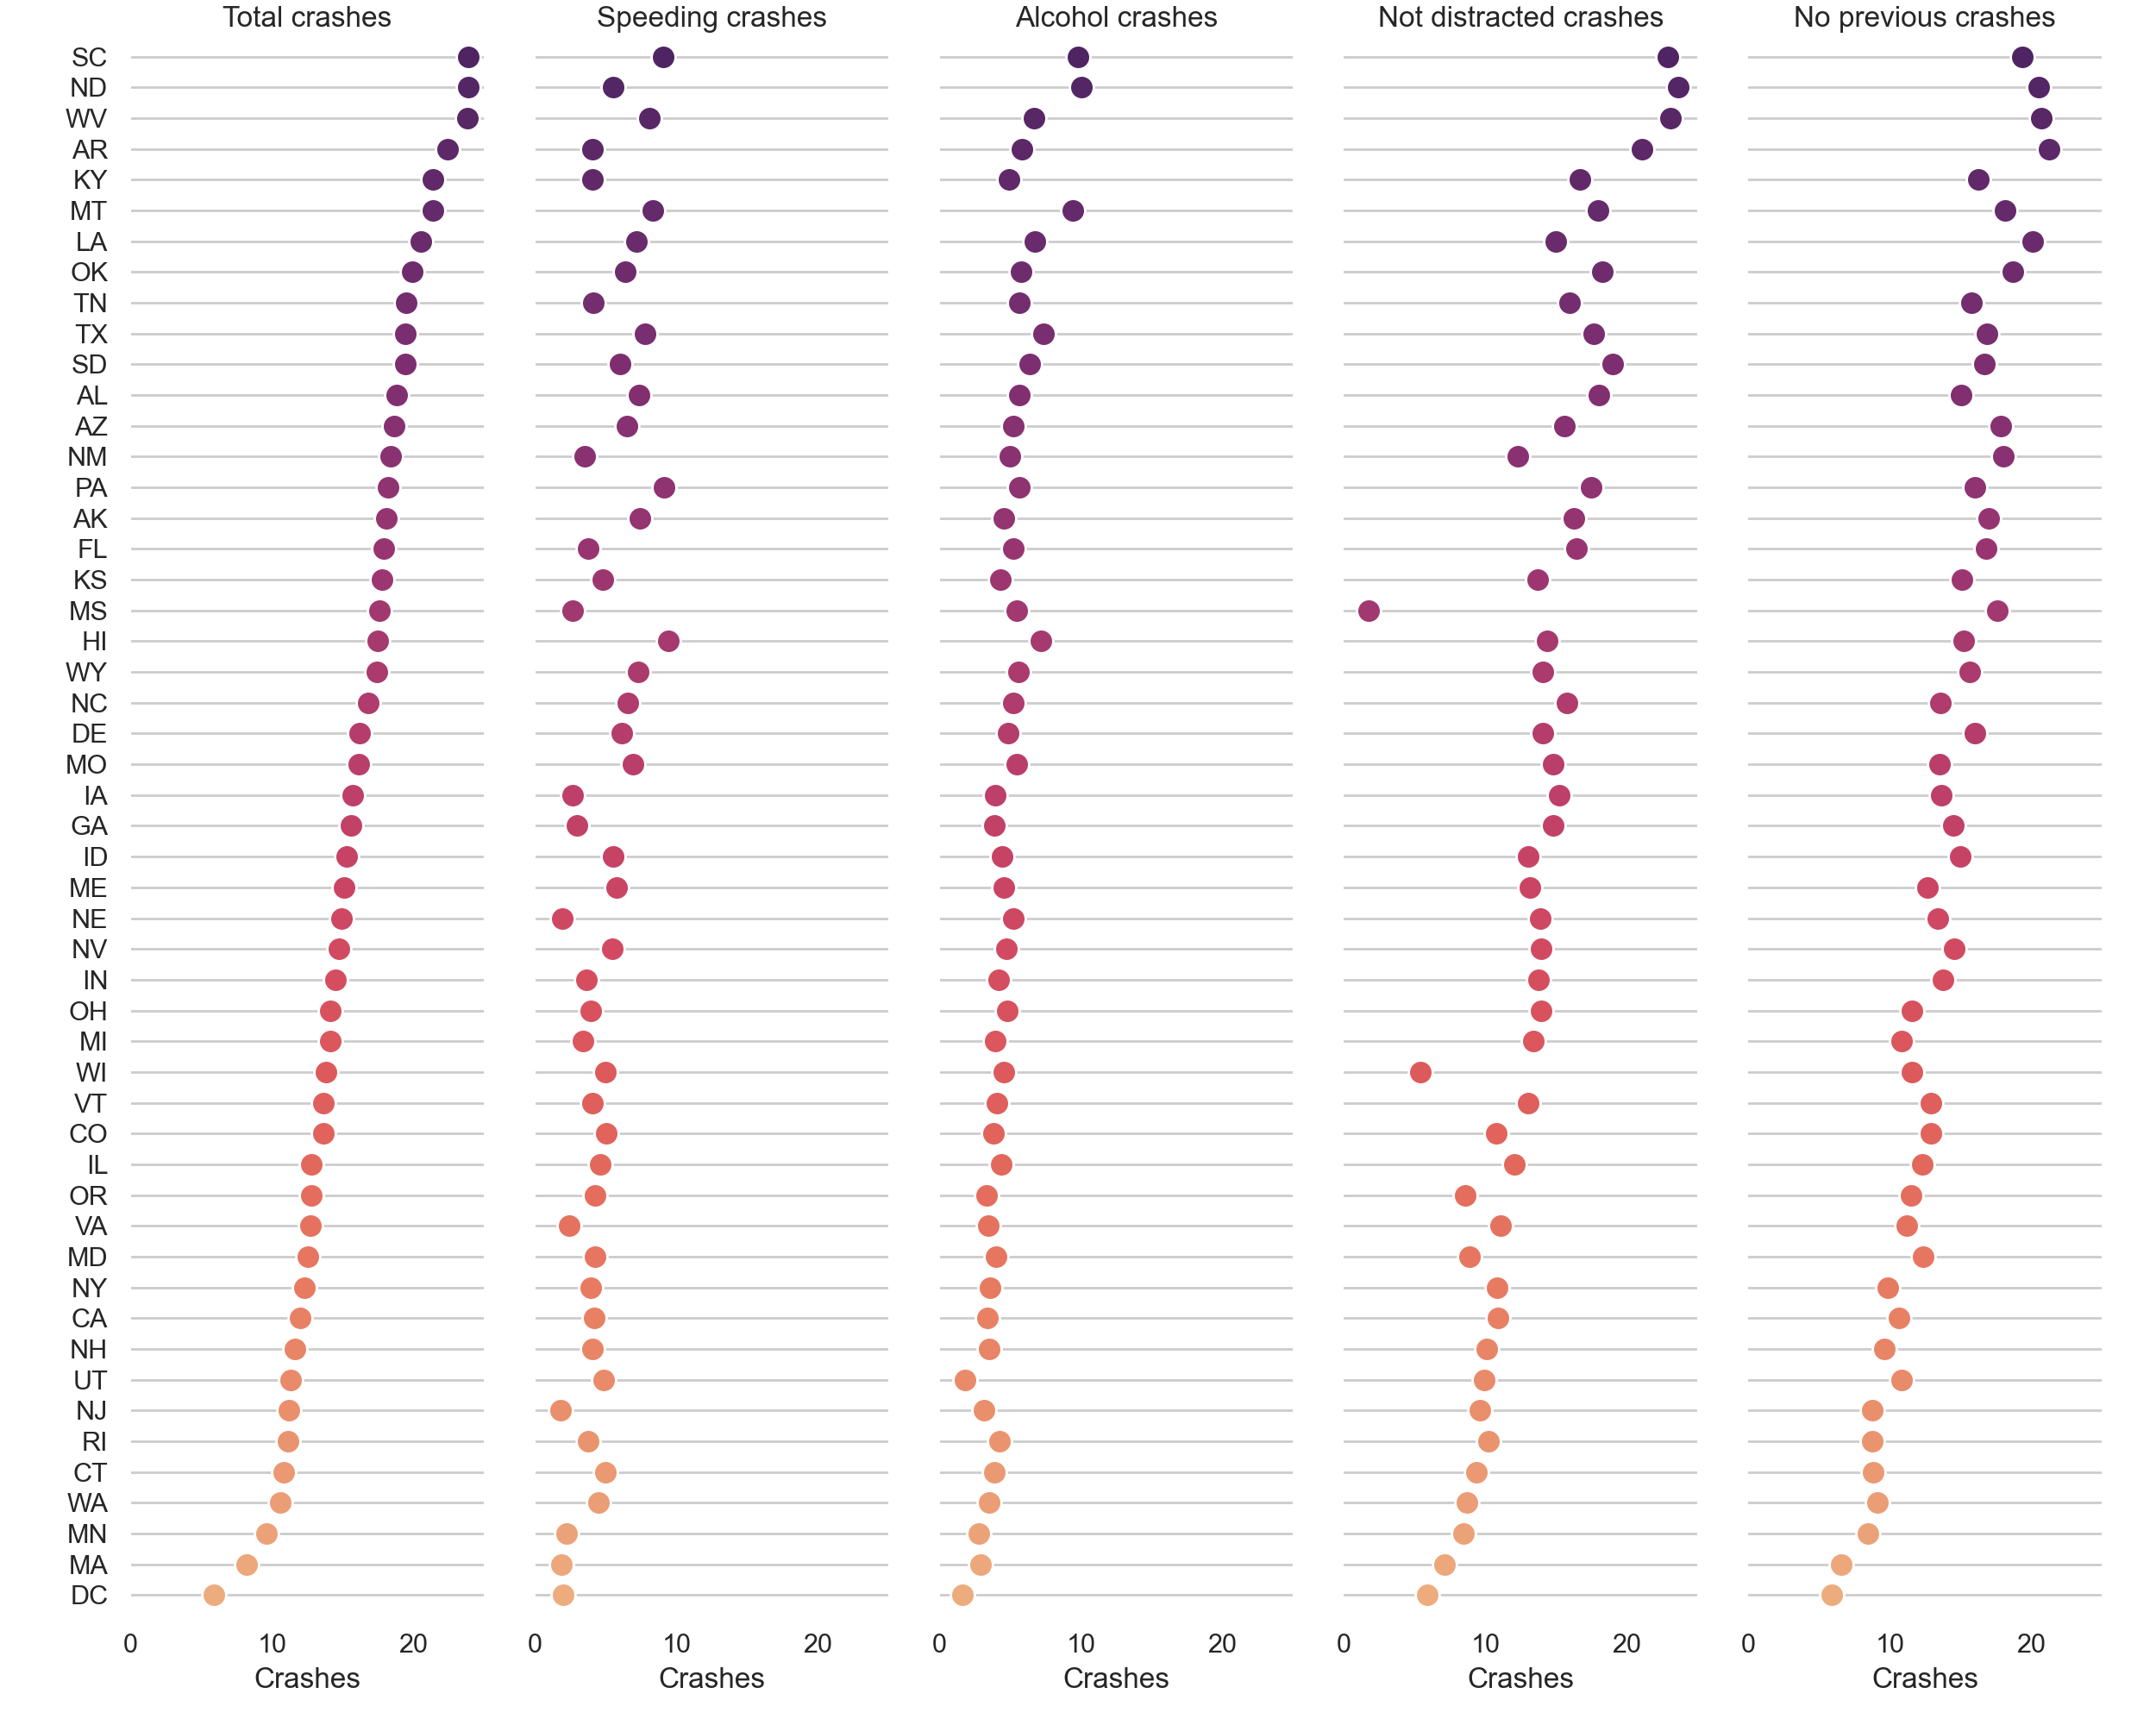

In [24]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# Load the dataset
crashes = sns.load_dataset("car_crashes")

# Make the PairGrid
g = sns.PairGrid(crashes.sort_values("total", ascending=False),
                 x_vars=crashes.columns[:-3], y_vars=["abbrev"],
                 height=10, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(0, 25), xlabel="Crashes", ylabel="")

# Use semantically meaningful titles for the columns
titles = ["Total crashes", "Speeding crashes", "Alcohol crashes",
          "Not distracted crashes", "No previous crashes"]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)


<IPython.core.display.Javascript object>


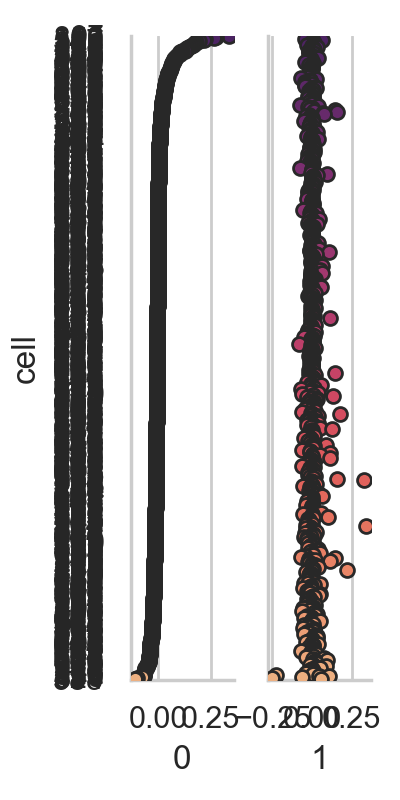

In [29]:
# Try to plot out ICA component weights - super slow
n_to_plot = 2
sns.set_theme(style='whitegrid')
g = sns.PairGrid(data=ct_df.sort_values(0, ascending=False), x_vars=ct_df.columns[0:n_to_plot], 
                 y_vars=["cell"], height=4, aspect=0.25)
g.map(sns.stripplot, orient="h", jitter=False, palette="flare_r", linewidth=1)


<IPython.core.display.Javascript object>


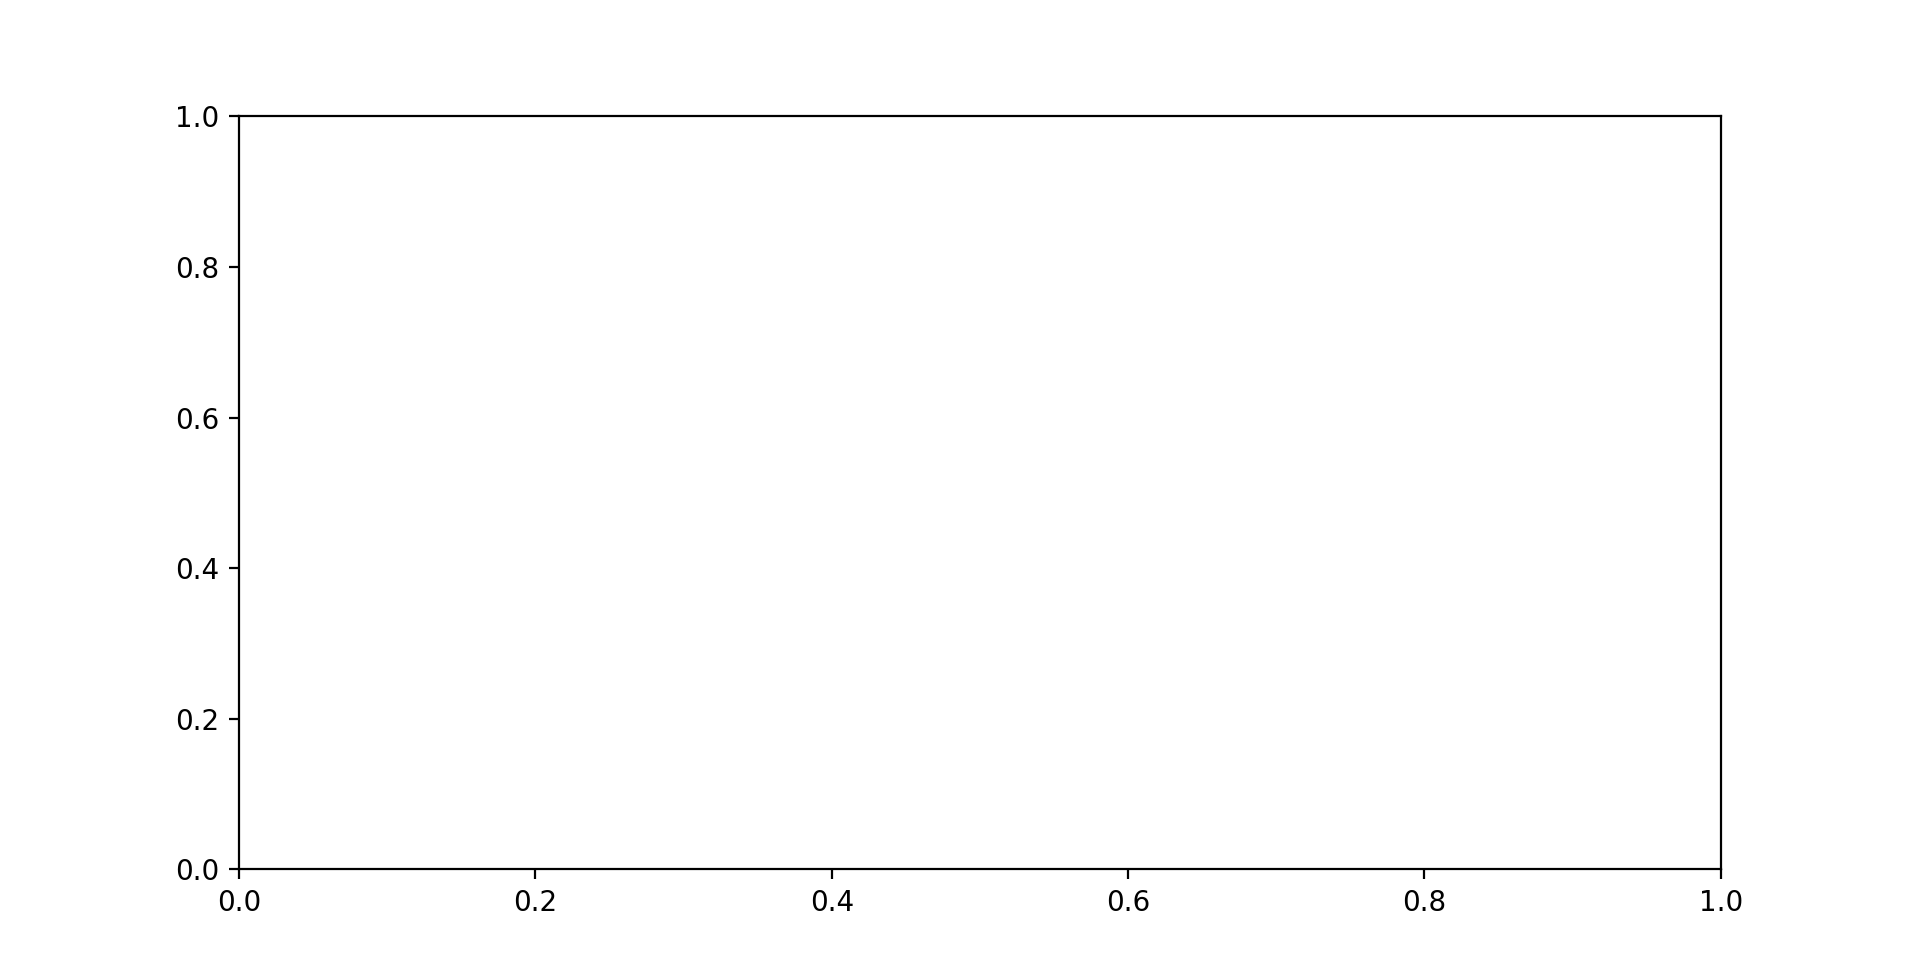

<AxesSubplot:>

In [13]:
%matplotlib notebook
